##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Neural style transfer

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/generative/style_transfer"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/style_transfer.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/style_transfer.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/generative/style_transfer.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial uses deep learning to compose one image in the style of another image (ever wish you could paint like Picasso or Van Gogh?). This is known as *neural style transfer* and the technique is outlined in <a href="https://arxiv.org/abs/1508.06576" class="external">A Neural Algorithm of Artistic Style</a> (Gatys et al.). 

Note: This tutorial demonstrates the original style-transfer algorithm. It optimizes the image content to a particular style. Modern approaches train a model to generate the stylized image directly (similar to [cyclegan](cyclegan.ipynb)). This approach is much faster (up to 1000x). A pretrained [Arbitrary Image Stylization module](https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/tf2_arbitrary_image_stylization.ipynb) is available in [TensorFlow Hub](https://tensorflow.org/hub), and for [TensorFlow Lite](https://www.tensorflow.org/lite/models/style_transfer/overview).

Neural style transfer is an optimization technique used to take two images—a *content* image and a *style reference* image (such as an artwork by a famous painter)—and blend them together so the output image looks like the content image, but “painted” in the style of the style reference image.

This is implemented by optimizing the output image to match the content statistics of the content image and the style statistics of the style reference image. These statistics are extracted from the images using a convolutional network.


For example, let’s take an image of this dog and Wassily Kandinsky's Composition 7:

<img src="https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg" width="500px"/>

[Yellow Labrador Looking](https://commons.wikimedia.org/wiki/File:YellowLabradorLooking_new.jpg), from Wikimedia Commons

<img src="https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg" width="500px"/>


Now how would it look like if Kandinsky decided to paint the picture of this Dog exclusively with this style? Something like this?

<img src="https://tensorflow.org/tutorials/generative/images/stylized-image.png" style="width: 500px;"/>

## Setup


### Import and configure modules

In [1]:
import tensorflow as tf

In [2]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [3]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

Download images and choose a style image and a content image:

In [4]:
content_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')

# https://commons.wikimedia.org/wiki/File:Vassily_Kandinsky,_1913_-_Composition_7.jpg
style_path = tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')

196608/195196 [==============================] - 0s 0us/step


## Visualize the input

Define a function to load an image and limit its maximum dimension to 512 pixels.

In [7]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

Create a simple function to display an image:

In [8]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

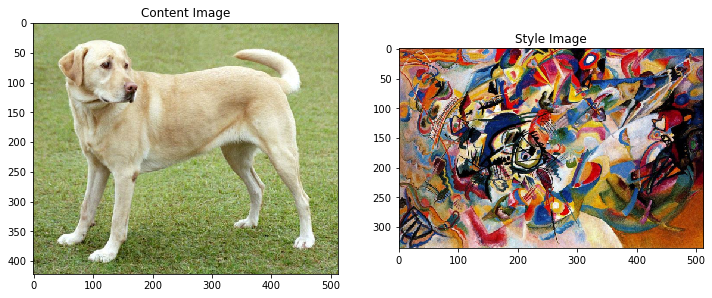

In [10]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

## Fast Style Transfer using TF-Hub

This tutorial demonstrates the original style-transfer algorithm. Which optimizes the image content to a particular style. Before getting into the details let's see how the [TensorFlow Hub](https://tensorflow.org/hub) module does:

In [11]:
import tensorflow_hub as hub
hub_module = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/1')
stylized_image = hub_module(tf.constant(content_image), tf.constant(style_image))[0]
tensor_to_image(stylized_image)

UnknownError:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node InceptionV3/Conv2d_1a_3x3/Conv2D (defined at C:\Users\jeang\Dropbox\usr\local\python37\lib\site-packages\tensorflow_hub\module_v2.py:95) ]] [Op:__inference_pruned_10054]

Function call stack:
pruned


## Define content and style representations

Use the intermediate layers of the model to get the *content* and *style* representations of the image. Starting from the network's input layer, the first few layer activations represent low-level features like edges and textures. As you step through the network, the final few layers represent higher-level features—object parts like *wheels* or *eyes*. In this case, you are using the VGG19 network architecture, a pretrained image classification network. These intermediate layers are necessary to define the representation of content and style from the images. For an input image, try to match the corresponding style and content target representations at these intermediate layers.


Load a [VGG19](https://keras.io/applications/#vgg19) and test run it on our image to ensure it's used correctly:

In [10]:
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

     8192/574710816 [..............................] - ETA: 3:30:31

    40960/574710816 [..............................] - ETA: 1:24:18

    90112/574710816 [..............................] - ETA: 57:31  

   163840/574710816 [..............................] - ETA: 42:09

   335872/574710816 [..............................] - ETA: 25:42

   679936/574710816 [..............................] - ETA: 15:13

  1392640/574710816 [..............................] - ETA: 8:39 

  2818048/574710816 [..............................] - ETA: 4:52

  5652480/574710816 [..............................] - ETA: 2:43

  8781824/574710816 [..............................] - ETA: 1:56

 11911168/574710816 [..............................] - ETA: 1:33

 15007744/574710816 [..............................] - ETA: 1:20

 18153472/574710816 [..............................] - ETA: 1:11

 21266432/574710816 [>.............................] - ETA: 1:05

 24395776/574710816 [>.............................] - ETA: 1:01

 27525120/574710816 [>.............................] - ETA: 54s 

 27541504/574710816 [>.............................] - ETA: 57s

 30654464/574710816 [>.............................] - ETA: 52s

 30670848/574710816 [>.............................] - ETA: 54s

 33767424/574710816 [>.............................] - ETA: 50s

 33800192/574710816 [>.............................] - ETA: 51s

 36798464/574710816 [>.............................] - ETA: 48s

 36913152/574710816 [>.............................] - ETA: 49s

 39878656/574710816 [=>............................] - ETA: 46s

 39960576/574710816 [=>............................] - ETA: 48s

 42991616/574710816 [=>............................] - ETA: 45s

 43040768/574710816 [=>............................] - ETA: 46s

 46104576/574710816 [=>............................] - ETA: 44s

 46153728/574710816 [=>............................] - ETA: 45s

 49217536/574710816 [=>............................] - ETA: 43s

 49250304/574710816 [=>............................] - ETA: 44s

 52346880/574710816 [=>............................] - ETA: 42s

 52363264/574710816 [=>............................] - ETA: 42s

 52396032/574710816 [=>............................] - ETA: 43s

 55476224/574710816 [=>............................] - ETA: 41s

 55492608/574710816 [=>............................] - ETA: 41s

 55508992/574710816 [=>............................] - ETA: 42s

 58556416/574710816 [==>...........................] - ETA: 40s

 58621952/574710816 [==>...........................] - ETA: 40s

 58638336/574710816 [==>...........................] - ETA: 41s

 61685760/574710816 [==>...........................] - ETA: 39s

 61718528/574710816 [==>...........................] - ETA: 39s

 61767680/574710816 [==>...........................] - ETA: 40s

 64798720/574710816 [==>...........................] - ETA: 38s

 64831488/574710816 [==>...........................] - ETA: 39s

 64897024/574710816 [==>...........................] - ETA: 39s

 67928064/574710816 [==>...........................] - ETA: 38s

 67960832/574710816 [==>...........................] - ETA: 38s

 68009984/574710816 [==>...........................] - ETA: 39s

 71057408/574710816 [==>...........................] - ETA: 37s

 71090176/574710816 [==>...........................] - ETA: 37s

 71139328/574710816 [==>...........................] - ETA: 38s

 74186752/574710816 [==>...........................] - ETA: 36s

 74219520/574710816 [==>...........................] - ETA: 37s

 74252288/574710816 [==>...........................] - ETA: 37s

 77299712/574710816 [===>..........................] - ETA: 36s

 77348864/574710816 [===>..........................] - ETA: 36s

 77381632/574710816 [===>..........................] - ETA: 37s

 80379904/574710816 [===>..........................] - ETA: 35s

 80478208/574710816 [===>..........................] - ETA: 36s

 80510976/574710816 [===>..........................] - ETA: 36s

 83623936/574710816 [===>..........................] - ETA: 35s

 83656704/574710816 [===>..........................] - ETA: 36s

 85311488/574710816 [===>..........................] - ETA: 35s

 86786048/574710816 [===>..........................] - ETA: 35s

 86802432/574710816 [===>..........................] - ETA: 35s

 88342528/574710816 [===>..........................] - ETA: 35s

 89915392/574710816 [===>..........................] - ETA: 35s

 91471872/574710816 [===>..........................] - ETA: 34s

 93028352/574710816 [===>..........................] - ETA: 34s

 93061120/574710816 [===>..........................] - ETA: 34s

 94601216/574710816 [===>..........................] - ETA: 34s

 96157696/574710816 [====>.........................] - ETA: 34s

 96174080/574710816 [====>.........................] - ETA: 34s

 97714176/574710816 [====>.........................] - ETA: 34s

 99287040/574710816 [====>.........................] - ETA: 33s

 99303424/574710816 [====>.........................] - ETA: 33s

100843520/574710816 [====>.........................] - ETA: 33s

102416384/574710816 [====>.........................] - ETA: 33s

102449152/574710816 [====>.........................] - ETA: 33s

103956480/574710816 [====>.........................] - ETA: 33s

105545728/574710816 [====>.........................] - ETA: 32s

105562112/574710816 [====>.........................] - ETA: 33s

107085824/574710816 [====>.........................] - ETA: 32s

108675072/574710816 [====>.........................] - ETA: 32s

108707840/574710816 [====>.........................] - ETA: 32s

110215168/574710816 [====>.........................] - ETA: 32s

111820800/574710816 [====>.........................] - ETA: 32s

113328128/574710816 [====>.........................] - ETA: 32s

114950144/574710816 [=====>........................] - ETA: 31s

114966528/574710816 [=====>........................] - ETA: 32s

116457472/574710816 [=====>........................] - ETA: 31s

118079488/574710816 [=====>........................] - ETA: 31s

118095872/574710816 [=====>........................] - ETA: 31s

119586816/574710816 [=====>........................] - ETA: 31s

121208832/574710816 [=====>........................] - ETA: 31s

121225216/574710816 [=====>........................] - ETA: 31s

122716160/574710816 [=====>........................] - ETA: 30s

124354560/574710816 [=====>........................] - ETA: 30s

125845504/574710816 [=====>........................] - ETA: 30s

127483904/574710816 [=====>........................] - ETA: 30s

128958464/574710816 [=====>........................] - ETA: 30s

130613248/574710816 [=====>........................] - ETA: 30s

130629632/574710816 [=====>........................] - ETA: 30s

132104192/574710816 [=====>........................] - ETA: 30s

133758976/574710816 [=====>........................] - ETA: 29s

135184384/574710816 [======>.......................] - ETA: 29s

136888320/574710816 [======>.......................] - ETA: 29s

138313728/574710816 [======>.......................] - ETA: 29s

140034048/574710816 [======>.......................] - ETA: 29s

141459456/574710816 [======>.......................] - ETA: 29s

143163392/574710816 [======>.......................] - ETA: 29s

144572416/574710816 [======>.......................] - ETA: 28s

146292736/574710816 [======>.......................] - ETA: 28s

146309120/574710816 [======>.......................] - ETA: 28s

147718144/574710816 [======>.......................] - ETA: 28s

149422080/574710816 [======>.......................] - ETA: 28s

149438464/574710816 [======>.......................] - ETA: 28s

150831104/574710816 [======>.......................] - ETA: 28s

152535040/574710816 [======>.......................] - ETA: 27s

152584192/574710816 [======>.......................] - ETA: 28s

153976832/574710816 [=======>......................] - ETA: 27s

155664384/574710816 [=======>......................] - ETA: 27s

155713536/574710816 [=======>......................] - ETA: 27s

157106176/574710816 [=======>......................] - ETA: 27s

158760960/574710816 [=======>......................] - ETA: 27s

158826496/574710816 [=======>......................] - ETA: 27s

160202752/574710816 [=======>......................] - ETA: 27s

161906688/574710816 [=======>......................] - ETA: 27s

161955840/574710816 [=======>......................] - ETA: 27s

163332096/574710816 [=======>......................] - ETA: 27s

164970496/574710816 [=======>......................] - ETA: 26s

165068800/574710816 [=======>......................] - ETA: 27s

166461440/574710816 [=======>......................] - ETA: 26s

168050688/574710816 [=======>......................] - ETA: 26s

168198144/574710816 [=======>......................] - ETA: 26s

169590784/574710816 [=======>......................] - ETA: 26s

171180032/574710816 [=======>......................] - ETA: 26s

171278336/574710816 [=======>......................] - ETA: 26s

172720128/574710816 [========>.....................] - ETA: 26s

174309376/574710816 [========>.....................] - ETA: 26s

174358528/574710816 [========>.....................] - ETA: 26s

175849472/574710816 [========>.....................] - ETA: 26s

177438720/574710816 [========>.....................] - ETA: 25s

177487872/574710816 [========>.....................] - ETA: 25s

178978816/574710816 [========>.....................] - ETA: 25s

180551680/574710816 [========>.....................] - ETA: 25s

180617216/574710816 [========>.....................] - ETA: 25s

182108160/574710816 [========>.....................] - ETA: 25s

183697408/574710816 [========>.....................] - ETA: 25s

183730176/574710816 [========>.....................] - ETA: 25s

185237504/574710816 [========>.....................] - ETA: 25s

186810368/574710816 [========>.....................] - ETA: 25s

186859520/574710816 [========>.....................] - ETA: 25s

188366848/574710816 [========>.....................] - ETA: 25s

189923328/574710816 [========>.....................] - ETA: 24s

189988864/574710816 [========>.....................] - ETA: 24s

191496192/574710816 [========>.....................] - ETA: 24s

193036288/574710816 [=========>....................] - ETA: 24s

193101824/574710816 [=========>....................] - ETA: 24s

194625536/574710816 [=========>....................] - ETA: 24s

196132864/574710816 [=========>....................] - ETA: 24s

196214784/574710816 [=========>....................] - ETA: 24s

197754880/574710816 [=========>....................] - ETA: 24s

199245824/574710816 [=========>....................] - ETA: 24s

199327744/574710816 [=========>....................] - ETA: 24s

200884224/574710816 [=========>....................] - ETA: 24s

202375168/574710816 [=========>....................] - ETA: 23s

202440704/574710816 [=========>....................] - ETA: 24s

204013568/574710816 [=========>....................] - ETA: 23s

205520896/574710816 [=========>....................] - ETA: 23s

207142912/574710816 [=========>....................] - ETA: 23s

208650240/574710816 [=========>....................] - ETA: 23s

208666624/574710816 [=========>....................] - ETA: 23s

210288640/574710816 [=========>....................] - ETA: 23s

211779584/574710816 [==========>...................] - ETA: 23s

211812352/574710816 [==========>...................] - ETA: 23s

213401600/574710816 [==========>...................] - ETA: 23s

214892544/574710816 [==========>...................] - ETA: 22s

214941696/574710816 [==========>...................] - ETA: 23s

216530944/574710816 [==========>...................] - ETA: 22s

218021888/574710816 [==========>...................] - ETA: 22s

218087424/574710816 [==========>...................] - ETA: 22s

219676672/574710816 [==========>...................] - ETA: 22s

221151232/574710816 [==========>...................] - ETA: 22s

221216768/574710816 [==========>...................] - ETA: 22s

222773248/574710816 [==========>...................] - ETA: 22s

224280576/574710816 [==========>...................] - ETA: 22s

224346112/574710816 [==========>...................] - ETA: 22s

225902592/574710816 [==========>...................] - ETA: 22s

227409920/574710816 [==========>...................] - ETA: 22s

227475456/574710816 [==========>...................] - ETA: 22s

228999168/574710816 [==========>...................] - ETA: 21s

230539264/574710816 [===========>..................] - ETA: 21s

230604800/574710816 [===========>..................] - ETA: 21s

232095744/574710816 [===========>..................] - ETA: 21s

233668608/574710816 [===========>..................] - ETA: 21s

233717760/574710816 [===========>..................] - ETA: 21s

235208704/574710816 [===========>..................] - ETA: 21s

236781568/574710816 [===========>..................] - ETA: 21s

236830720/574710816 [===========>..................] - ETA: 21s

238338048/574710816 [===========>..................] - ETA: 21s

239927296/574710816 [===========>..................] - ETA: 21s

241467392/574710816 [===========>..................] - ETA: 21s

243056640/574710816 [===========>..................] - ETA: 20s

244580352/574710816 [===========>..................] - ETA: 20s

246185984/574710816 [===========>..................] - ETA: 20s

246218752/574710816 [===========>..................] - ETA: 20s

247693312/574710816 [===========>..................] - ETA: 20s

249331712/574710816 [============>.................] - ETA: 20s

250822656/574710816 [============>.................] - ETA: 20s

252461056/574710816 [============>.................] - ETA: 20s

252477440/574710816 [============>.................] - ETA: 20s

253952000/574710816 [============>.................] - ETA: 20s

255590400/574710816 [============>.................] - ETA: 20s

255606784/574710816 [============>.................] - ETA: 20s

257081344/574710816 [============>.................] - ETA: 19s

258736128/574710816 [============>.................] - ETA: 19s

260030464/574710816 [============>.................] - ETA: 19s

261865472/574710816 [============>.................] - ETA: 19s

263159808/574710816 [============>.................] - ETA: 19s

264994816/574710816 [============>.................] - ETA: 19s

266289152/574710816 [============>.................] - ETA: 19s

268124160/574710816 [============>.................] - ETA: 19s

268140544/574710816 [============>.................] - ETA: 19s

269402112/574710816 [=============>................] - ETA: 19s

271237120/574710816 [=============>................] - ETA: 18s

271286272/574710816 [=============>................] - ETA: 19s

272515072/574710816 [=============>................] - ETA: 18s

274366464/574710816 [=============>................] - ETA: 18s

274415616/574710816 [=============>................] - ETA: 18s

275660800/574710816 [=============>................] - ETA: 18s

277512192/574710816 [=============>................] - ETA: 18s

278790144/574710816 [=============>................] - ETA: 18s

280641536/574710816 [=============>................] - ETA: 18s

280657920/574710816 [=============>................] - ETA: 18s

281919488/574710816 [=============>................] - ETA: 18s

283770880/574710816 [=============>................] - ETA: 18s

283787264/574710816 [=============>................] - ETA: 18s

285048832/574710816 [=============>................] - ETA: 18s

286900224/574710816 [=============>................] - ETA: 17s

286932992/574710816 [=============>................] - ETA: 17s

288161792/574710816 [==============>...............] - ETA: 17s

290029568/574710816 [==============>...............] - ETA: 17s

290062336/574710816 [==============>...............] - ETA: 17s

291291136/574710816 [==============>...............] - ETA: 17s

293158912/574710816 [==============>...............] - ETA: 17s

293191680/574710816 [==============>...............] - ETA: 17s

294420480/574710816 [==============>...............] - ETA: 17s

296271872/574710816 [==============>...............] - ETA: 17s

296321024/574710816 [==============>...............] - ETA: 17s

297549824/574710816 [==============>...............] - ETA: 17s

299401216/574710816 [==============>...............] - ETA: 17s

299433984/574710816 [==============>...............] - ETA: 17s

300662784/574710816 [==============>...............] - ETA: 17s

302530560/574710816 [==============>...............] - ETA: 16s

302563328/574710816 [==============>...............] - ETA: 16s

303775744/574710816 [==============>...............] - ETA: 16s

305659904/574710816 [==============>...............] - ETA: 16s

305692672/574710816 [==============>...............] - ETA: 16s

306905088/574710816 [===============>..............] - ETA: 16s

308805632/574710816 [===============>..............] - ETA: 16s

310034432/574710816 [===============>..............] - ETA: 16s

311934976/574710816 [===============>..............] - ETA: 16s

311951360/574710816 [===============>..............] - ETA: 16s

313163776/574710816 [===============>..............] - ETA: 16s

315064320/574710816 [===============>..............] - ETA: 16s

315080704/574710816 [===============>..............] - ETA: 16s

316293120/574710816 [===============>..............] - ETA: 16s

318210048/574710816 [===============>..............] - ETA: 15s

319422464/574710816 [===============>..............] - ETA: 15s

321339392/574710816 [===============>..............] - ETA: 15s

321355776/574710816 [===============>..............] - ETA: 15s

322879488/574710816 [===============>..............] - ETA: 15s

324485120/574710816 [===============>..............] - ETA: 15s

325697536/574710816 [================>.............] - ETA: 15s

327614464/574710816 [================>.............] - ETA: 15s

328826880/574710816 [================>.............] - ETA: 15s

330743808/574710816 [================>.............] - ETA: 15s

330760192/574710816 [================>.............] - ETA: 15s

332283904/574710816 [================>.............] - ETA: 14s

333889536/574710816 [================>.............] - ETA: 14s

335085568/574710816 [================>.............] - ETA: 14s

337018880/574710816 [================>.............] - ETA: 14s

338214912/574710816 [================>.............] - ETA: 14s

340131840/574710816 [================>.............] - ETA: 14s

340164608/574710816 [================>.............] - ETA: 14s

341344256/574710816 [================>.............] - ETA: 14s

343261184/574710816 [================>.............] - ETA: 14s

343293952/574710816 [================>.............] - ETA: 14s

344473600/574710816 [================>.............] - ETA: 14s

346390528/574710816 [=================>............] - ETA: 14s

346423296/574710816 [=================>............] - ETA: 14s

347619328/574710816 [=================>............] - ETA: 13s

349503488/574710816 [=================>............] - ETA: 13s

349552640/574710816 [=================>............] - ETA: 13s

350748672/574710816 [=================>............] - ETA: 13s

352632832/574710816 [=================>............] - ETA: 13s

352681984/574710816 [=================>............] - ETA: 13s

353861632/574710816 [=================>............] - ETA: 13s

355762176/574710816 [=================>............] - ETA: 13s

355794944/574710816 [=================>............] - ETA: 13s

357007360/574710816 [=================>............] - ETA: 13s

358891520/574710816 [=================>............] - ETA: 13s

358924288/574710816 [=================>............] - ETA: 13s

360120320/574710816 [=================>............] - ETA: 13s

362020864/574710816 [=================>............] - ETA: 13s

362053632/574710816 [=================>............] - ETA: 13s

363249664/574710816 [=================>............] - ETA: 12s

365101056/574710816 [==================>...........] - ETA: 12s

365182976/574710816 [==================>...........] - ETA: 12s

366346240/574710816 [==================>...........] - ETA: 12s

368181248/574710816 [==================>...........] - ETA: 12s

368312320/574710816 [==================>...........] - ETA: 12s

369475584/574710816 [==================>...........] - ETA: 12s

371310592/574710816 [==================>...........] - ETA: 12s

371408896/574710816 [==================>...........] - ETA: 12s

372604928/574710816 [==================>...........] - ETA: 12s

374423552/574710816 [==================>...........] - ETA: 12s

374505472/574710816 [==================>...........] - ETA: 12s

375750656/574710816 [==================>...........] - ETA: 12s

377552896/574710816 [==================>...........] - ETA: 12s

377602048/574710816 [==================>...........] - ETA: 12s

378880000/574710816 [==================>...........] - ETA: 11s

380682240/574710816 [==================>...........] - ETA: 11s

380731392/574710816 [==================>...........] - ETA: 11s

382009344/574710816 [==================>...........] - ETA: 11s

383811584/574710816 [===================>..........] - ETA: 11s

383844352/574710816 [===================>..........] - ETA: 11s

385138688/574710816 [===================>..........] - ETA: 11s

386940928/574710816 [===================>..........] - ETA: 11s

386973696/574710816 [===================>..........] - ETA: 11s

388268032/574710816 [===================>..........] - ETA: 11s

390070272/574710816 [===================>..........] - ETA: 11s

390103040/574710816 [===================>..........] - ETA: 11s

391413760/574710816 [===================>..........] - ETA: 11s

393199616/574710816 [===================>..........] - ETA: 11s

393232384/574710816 [===================>..........] - ETA: 11s

394543104/574710816 [===================>..........] - ETA: 11s

396328960/574710816 [===================>..........] - ETA: 10s

396361728/574710816 [===================>..........] - ETA: 10s

397672448/574710816 [===================>..........] - ETA: 10s

399458304/574710816 [===================>..........] - ETA: 10s

399491072/574710816 [===================>..........] - ETA: 10s

400818176/574710816 [===================>..........] - ETA: 10s

402587648/574710816 [====================>.........] - ETA: 10s

402620416/574710816 [====================>.........] - ETA: 10s

403947520/574710816 [====================>.........] - ETA: 10s

405716992/574710816 [====================>.........] - ETA: 10s

405749760/574710816 [====================>.........] - ETA: 10s

407166976/574710816 [====================>.........] - ETA: 10s

408829952/574710816 [====================>.........] - ETA: 10s

408879104/574710816 [====================>.........] - ETA: 10s

410206208/574710816 [====================>.........] - ETA: 10s

411959296/574710816 [====================>.........] - ETA: 9s 

412008448/574710816 [====================>.........] - ETA: 9s

413335552/574710816 [====================>.........] - ETA: 9s

415105024/574710816 [====================>.........] - ETA: 9s

416481280/574710816 [====================>.........] - ETA: 9s

418217984/574710816 [====================>.........] - ETA: 9s

418250752/574710816 [====================>.........] - ETA: 9s

419577856/574710816 [====================>.........] - ETA: 9s

421330944/574710816 [====================>.........] - ETA: 9s

421380096/574710816 [====================>.........] - ETA: 9s

422723584/574710816 [=====================>........] - ETA: 9s

424443904/574710816 [=====================>........] - ETA: 9s

424509440/574710816 [=====================>........] - ETA: 9s

425820160/574710816 [=====================>........] - ETA: 9s

427573248/574710816 [=====================>........] - ETA: 8s

427622400/574710816 [=====================>........] - ETA: 8s

428949504/574710816 [=====================>........] - ETA: 8s

430718976/574710816 [=====================>........] - ETA: 8s

432078848/574710816 [=====================>........] - ETA: 8s

433848320/574710816 [=====================>........] - ETA: 8s

435208192/574710816 [=====================>........] - ETA: 8s

436977664/574710816 [=====================>........] - ETA: 8s

436994048/574710816 [=====================>........] - ETA: 8s

438353920/574710816 [=====================>........] - ETA: 8s

440123392/574710816 [=====================>........] - ETA: 8s

441466880/574710816 [======================>.......] - ETA: 8s

443252736/574710816 [======================>.......] - ETA: 7s

443269120/574710816 [======================>.......] - ETA: 7s

444612608/574710816 [======================>.......] - ETA: 7s

446398464/574710816 [======================>.......] - ETA: 7s

447725568/574710816 [======================>.......] - ETA: 7s

449527808/574710816 [======================>.......] - ETA: 7s

450854912/574710816 [======================>.......] - ETA: 7s

452657152/574710816 [======================>.......] - ETA: 7s

452673536/574710816 [======================>.......] - ETA: 7s

454033408/574710816 [======================>.......] - ETA: 7s

455802880/574710816 [======================>.......] - ETA: 7s

457080832/574710816 [======================>.......] - ETA: 7s

458932224/574710816 [======================>.......] - ETA: 7s

460193792/574710816 [=======================>......] - ETA: 6s

462061568/574710816 [=======================>......] - ETA: 6s

462077952/574710816 [=======================>......] - ETA: 6s

463306752/574710816 [=======================>......] - ETA: 6s

465190912/574710816 [=======================>......] - ETA: 6s

465207296/574710816 [=======================>......] - ETA: 6s

466436096/574710816 [=======================>......] - ETA: 6s

468336640/574710816 [=======================>......] - ETA: 6s

469565440/574710816 [=======================>......] - ETA: 6s

471465984/574710816 [=======================>......] - ETA: 6s

472694784/574710816 [=======================>......] - ETA: 6s

474595328/574710816 [=======================>......] - ETA: 6s

474611712/574710816 [=======================>......] - ETA: 6s

475824128/574710816 [=======================>......] - ETA: 5s

477724672/574710816 [=======================>......] - ETA: 5s

477741056/574710816 [=======================>......] - ETA: 5s

478953472/574710816 [========================>.....] - ETA: 5s

480854016/574710816 [========================>.....] - ETA: 5s

480886784/574710816 [========================>.....] - ETA: 5s

482099200/574710816 [========================>.....] - ETA: 5s

483966976/574710816 [========================>.....] - ETA: 5s

484016128/574710816 [========================>.....] - ETA: 5s

485212160/574710816 [========================>.....] - ETA: 5s

487112704/574710816 [========================>.....] - ETA: 5s

488341504/574710816 [========================>.....] - ETA: 5s

490242048/574710816 [========================>.....] - ETA: 5s

490258432/574710816 [========================>.....] - ETA: 5s

491470848/574710816 [========================>.....] - ETA: 5s

493355008/574710816 [========================>.....] - ETA: 4s

493404160/574710816 [========================>.....] - ETA: 4s

494616576/574710816 [========================>.....] - ETA: 4s

496484352/574710816 [========================>.....] - ETA: 4s

496533504/574710816 [========================>.....] - ETA: 4s

497713152/574710816 [========================>.....] - ETA: 4s

499597312/574710816 [=========================>....] - ETA: 4s

499646464/574710816 [=========================>....] - ETA: 4s

500842496/574710816 [=========================>....] - ETA: 4s

502743040/574710816 [=========================>....] - ETA: 4s

503988224/574710816 [=========================>....] - ETA: 4s

505790464/574710816 [=========================>....] - ETA: 4s

505888768/574710816 [=========================>....] - ETA: 4s

507101184/574710816 [=========================>....] - ETA: 4s

508919808/574710816 [=========================>....] - ETA: 3s

509034496/574710816 [=========================>....] - ETA: 3s

510246912/574710816 [=========================>....] - ETA: 3s

512049152/574710816 [=========================>....] - ETA: 3s

512163840/574710816 [=========================>....] - ETA: 3s

513359872/574710816 [=========================>....] - ETA: 3s

515178496/574710816 [=========================>....] - ETA: 3s

515227648/574710816 [=========================>....] - ETA: 3s

516489216/574710816 [=========================>....] - ETA: 3s

518324224/574710816 [==========================>...] - ETA: 3s

519618560/574710816 [==========================>...] - ETA: 3s

521453568/574710816 [==========================>...] - ETA: 3s

521469952/574710816 [==========================>...] - ETA: 3s

522764288/574710816 [==========================>...] - ETA: 3s

524599296/574710816 [==========================>...] - ETA: 3s

525893632/574710816 [==========================>...] - ETA: 2s

527728640/574710816 [==========================>...] - ETA: 2s

529006592/574710816 [==========================>...] - ETA: 2s

530857984/574710816 [==========================>...] - ETA: 2s

530874368/574710816 [==========================>...] - ETA: 2s

532103168/574710816 [==========================>...] - ETA: 2s

533987328/574710816 [==========================>...] - ETA: 2s

534003712/574710816 [==========================>...] - ETA: 2s

535232512/574710816 [==========================>...] - ETA: 2s

537116672/574710816 [===========================>..] - ETA: 2s

537149440/574710816 [===========================>..] - ETA: 2s

538378240/574710816 [===========================>..] - ETA: 2s

540246016/574710816 [===========================>..] - ETA: 2s

540278784/574710816 [===========================>..] - ETA: 2s

541507584/574710816 [===========================>..] - ETA: 1s

543375360/574710816 [===========================>..] - ETA: 1s

543408128/574710816 [===========================>..] - ETA: 1s

544604160/574710816 [===========================>..] - ETA: 1s

546504704/574710816 [===========================>..] - ETA: 1s

546521088/574710816 [===========================>..] - ETA: 1s

547700736/574710816 [===========================>..] - ETA: 1s

549634048/574710816 [===========================>..] - ETA: 1s

549666816/574710816 [===========================>..] - ETA: 1s

550862848/574710816 [===========================>..] - ETA: 1s

552763392/574710816 [===========================>..] - ETA: 1s

552796160/574710816 [===========================>..] - ETA: 1s

553926656/574710816 [===========================>..] - ETA: 1s

555876352/574710816 [============================>.] - ETA: 1s

555925504/574710816 [============================>.] - ETA: 1s

557056000/574710816 [============================>.] - ETA: 1s

559005696/574710816 [============================>.] - ETA: 0s

559054848/574710816 [============================>.] - ETA: 0s

560201728/574710816 [============================>.] - ETA: 0s

562069504/574710816 [============================>.] - ETA: 0s

562167808/574710816 [============================>.] - ETA: 0s

563314688/574710816 [============================>.] - ETA: 0s

565182464/574710816 [============================>.] - ETA: 0s

565297152/574710816 [============================>.] - ETA: 0s

566444032/574710816 [============================>.] - ETA: 0s

568295424/574710816 [============================>.] - ETA: 0s

568426496/574710816 [============================>.] - ETA: 0s

569573376/574710816 [============================>.] - ETA: 0s

571408384/574710816 [============================>.] - ETA: 0s

571555840/574710816 [============================>.] - ETA: 0s

572702720/574710816 [============================>.] - ETA: 0s

574537728/574710816 [============================>.] - ETA: 0s

574668800/574710816 [============================>.] - ETA: 0s

574717952/574710816 [==============================] - 35s 0us/step


TensorShape([1, 1000])

In [11]:
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

 8192/35363 [=====>........................] - ETA: 0s

40960/35363 [==================================] - 0s 0us/step


[('Labrador_retriever', 0.49317157),
 ('golden_retriever', 0.2366525),
 ('kuvasz', 0.03635752),
 ('Chesapeake_Bay_retriever', 0.02418279),
 ('Greater_Swiss_Mountain_dog', 0.018646086)]

Now load a `VGG19` without the classification head, and list the layer names

In [12]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
  print(layer.name)

    8192/80134624 [..............................] - ETA: 12s

   24576/80134624 [..............................] - ETA: 9:53

   57344/80134624 [..............................] - ETA: 8:29

   90112/80134624 [..............................] - ETA: 8:06

  139264/80134624 [..............................] - ETA: 6:59

  278528/80134624 [..............................] - ETA: 4:21

  598016/80134624 [..............................] - ETA: 2:25

 1187840/80134624 [..............................] - ETA: 1:24

 2408448/80134624 [..............................] - ETA: 47s 

 4833280/80134624 [>.............................] - ETA: 25s

 7962624/80134624 [=>............................] - ETA: 16s

11075584/80134624 [===>..........................] - ETA: 12s

14204928/80134624 [====>.........................] - ETA: 10s

17334272/80134624 [=====>........................] - ETA: 8s 

20463616/80134624 [======>.......................] - ETA: 7s

23576576/80134624 [=======>......................] - ETA: 6s

26624000/80134624 [========>.....................] - ETA: 5s

29687808/80134624 [==========>...................] - ETA: 5s

32768000/80134624 [===========>..................] - ETA: 4s

35897344/80134624 [============>.................] - ETA: 4s

38993920/80134624 [=============>................] - ETA: 3s

42090496/80134624 [==============>...............] - ETA: 3s

45203456/80134624 [===============>..............] - ETA: 3s

48332800/80134624 [=================>............] - ETA: 2s

51445760/80134624 [==================>...........] - ETA: 2s

54558720/80134624 [===================>..........] - ETA: 2s

57688064/80134624 [====================>.........] - ETA: 1s

60817408/80134624 [=====================>........] - ETA: 1s

63930368/80134624 [======================>.......] - ETA: 1s

67059712/80134624 [========================>.....] - ETA: 1s

70189056/80134624 [=========================>....] - ETA: 0s

73302016/80134624 [==========================>...] - ETA: 0s

76431360/80134624 [===========================>..] - ETA: 0s

79560704/80134624 [============================>.] - ETA: 0s

80142336/80134624 [==============================] - 6s 0us/step



input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


Choose intermediate layers from the network to represent the style and content of the image:


In [13]:
# Content layer where will pull our feature maps
content_layers = ['block5_conv2'] 

# Style layer of interest
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

#### Intermediate layers for style and content

So why do these intermediate outputs within our pretrained image classification network allow us to define style and content representations?

At a high level, in order for a network to perform image classification (which this network has been trained to do), it must understand the image. This requires taking the raw image as input pixels and building an internal representation that converts the raw image pixels into a complex understanding of the features present within the image.

This is also a reason why convolutional neural networks are able to generalize well: they’re able to capture the invariances and defining features within classes (e.g. cats vs. dogs) that are agnostic to background noise and other nuisances. Thus, somewhere between where the raw image is fed into the model and the output classification label, the model serves as a complex feature extractor. By accessing intermediate layers of the model, you're able to describe the content and style of input images.

## Build the model 

The networks in `tf.keras.applications` are designed so you can easily extract the intermediate layer values using the Keras functional API.

To define a model using the functional API, specify the inputs and outputs:

`model = Model(inputs, outputs)`

This following function builds a VGG19 model that returns a list of intermediate layer outputs:

In [14]:
def vgg_layers(layer_names):
  """ Creates a vgg model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on imagenet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  
  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

And to create the model:

In [15]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

block1_conv1
  shape:  (1, 336, 512, 64)
  min:  0.0
  max:  835.5256
  mean:  33.97525

block2_conv1
  shape:  (1, 168, 256, 128)
  min:  0.0
  max:  4625.8857
  mean:  199.82687

block3_conv1
  shape:  (1, 84, 128, 256)
  min:  0.0
  max:  8789.239
  mean:  230.78099

block4_conv1
  shape:  (1, 42, 64, 512)
  min:  0.0
  max:  21566.135
  mean:  791.24005

block5_conv1
  shape:  (1, 21, 32, 512)
  min:  0.0
  max:  3189.2542
  mean:  59.179478



## Calculate style

The content of an image is represented by the values of the intermediate feature maps.

It turns out, the style of an image can be described by the means and correlations across the different feature maps. Calculate a Gram matrix that includes this information by taking the outer product of the feature vector with itself at each location, and averaging that outer product over all locations. This Gram matrix can be calcualted for a particular layer as:

$$G^l_{cd} = \frac{\sum_{ij} F^l_{ijc}(x)F^l_{ijd}(x)}{IJ}$$

This can be implemented concisely using the `tf.linalg.einsum` function:

In [16]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

## Extract style and content


Build a model that returns the style and content tensors.

In [17]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg =  vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name:value 
                    for content_name, value 
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}
    
    return {'content':content_dict, 'style':style_dict}

When called on an image, this model returns the gram matrix (style) of the `style_layers` and content of the `content_layers`:

In [18]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

style_results = results['style']

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())


Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.0055228462
    max:  28014.566
    mean:  263.79025

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  61479.49
    mean:  9100.949

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  545623.4
    mean:  7660.976

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  4320502.0
    mean:  134288.84

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  110005.37
    mean:  1487.0381

Contents:
   block5_conv2
    shape:  (1, 26, 32, 512)
    min:  0.0
    max:  2410.8796
    mean:  13.764149


## Run gradient descent

With this style and content extractor, you can now implement the style transfer algorithm. Do this by calculating the mean square error for your image's output relative to each target, then take the weighted sum of these losses.

Set your style and content target values:

In [19]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

Define a `tf.Variable` to contain the image to optimize. To make this quick, initialize it with the content image (the `tf.Variable` must be the same shape as the content image):

In [20]:
image = tf.Variable(content_image)

Since this is a float image, define a function to keep the pixel values between 0 and 1:

In [21]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

Create an optimizer. The paper recommends LBFGS, but `Adam` works okay, too:

In [22]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

To optimize this, use a weighted combination of the two losses to get the total loss:

In [23]:
style_weight=1e-2
content_weight=1e4

In [24]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

Use `tf.GradientTape` to update the image.

In [25]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

Now run a few steps to test:

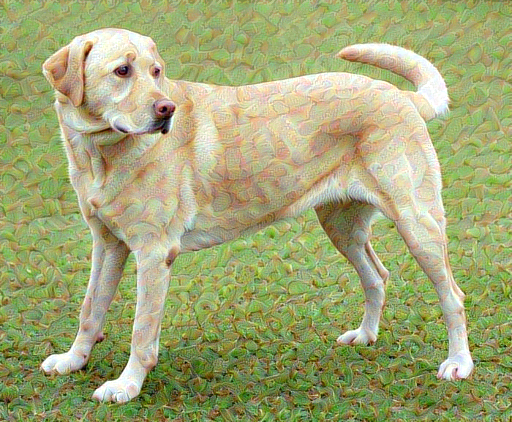

In [26]:
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

Since it's working, perform a longer optimization:

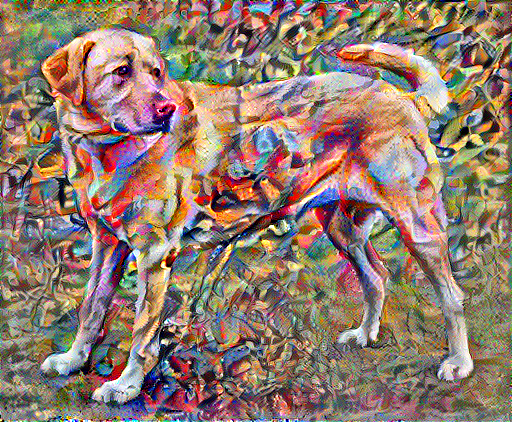

Train step: 1000
Total time: 22.8


In [27]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='')
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))
  
end = time.time()
print("Total time: {:.1f}".format(end-start))

## Total variation loss

One downside to this basic implementation is that it produces a lot of high frequency artifacts. Decrease these using an explicit regularization term on the high frequency components of the image. In style transfer, this is often called the *total variation loss*:

In [28]:
def high_pass_x_y(image):
  x_var = image[:,:,1:,:] - image[:,:,:-1,:]
  y_var = image[:,1:,:,:] - image[:,:-1,:,:]

  return x_var, y_var

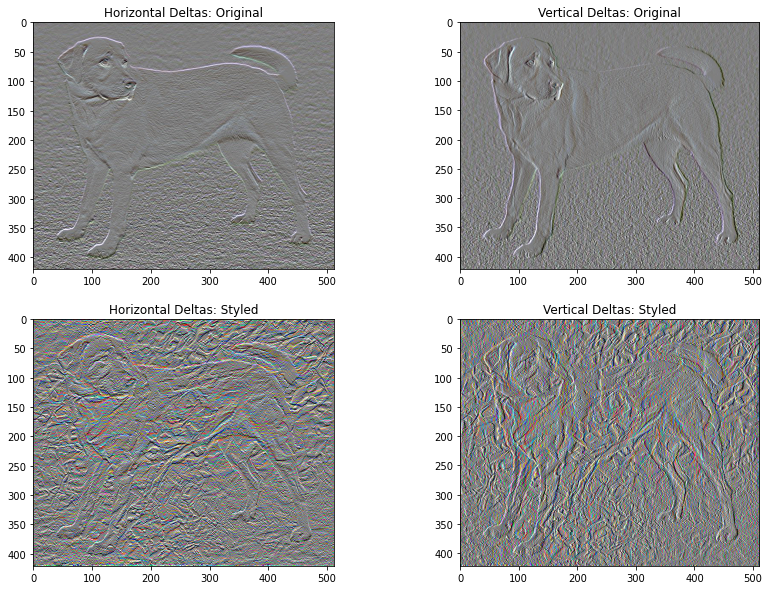

In [29]:
x_deltas, y_deltas = high_pass_x_y(content_image)

plt.figure(figsize=(14,10))
plt.subplot(2,2,1)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Original")

plt.subplot(2,2,2)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Original")

x_deltas, y_deltas = high_pass_x_y(image)

plt.subplot(2,2,3)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Styled")

plt.subplot(2,2,4)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Styled")

This shows how the high frequency components have increased.

Also, this high frequency component is basically an edge-detector. You can get similar output from the Sobel edge detector, for example:

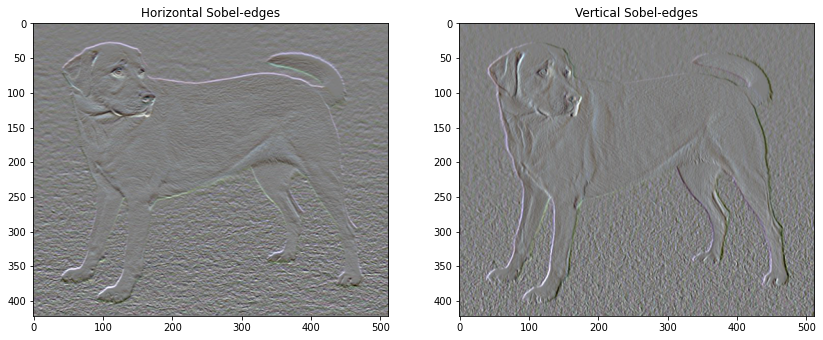

In [30]:
plt.figure(figsize=(14,10))

sobel = tf.image.sobel_edges(content_image)
plt.subplot(1,2,1)
imshow(clip_0_1(sobel[...,0]/4+0.5), "Horizontal Sobel-edges")
plt.subplot(1,2,2)
imshow(clip_0_1(sobel[...,1]/4+0.5), "Vertical Sobel-edges")

The regularization loss associated with this is the sum of the squares of the values:

In [31]:
def total_variation_loss(image):
  x_deltas, y_deltas = high_pass_x_y(image)
  return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

In [32]:
total_variation_loss(image).numpy()

149315.17

That demonstrated what it does. But there's no need to implement it yourself, TensorFlow includes a standard implementation:

In [33]:
tf.image.total_variation(image).numpy()

array([149315.17], dtype=float32)

## Re-run the optimization

Choose a weight for the `total_variation_loss`:

In [34]:
total_variation_weight=30

Now include it in the `train_step` function:

In [35]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

Reinitialize the optimization variable:

In [36]:
image = tf.Variable(content_image)

And run the optimization:

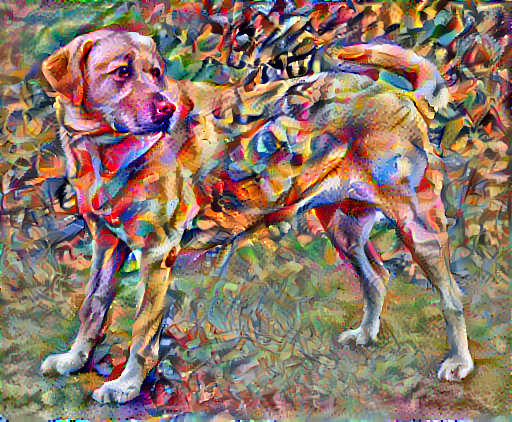

Train step: 1000
Total time: 23.8


In [37]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='')
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

Finally, save the result:

In [38]:
file_name = 'stylized-image.png'
tensor_to_image(image).save(file_name)

try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(file_name)